In [16]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
from scipy.stats import gaussian_kde
from astropy.cosmology import Planck18 as cosmo
from scipy.spatial import cKDTree

import matplotlib
from matplotlib import pyplot as plt

# import fitsio
from scipy.spatial.distance import cdist

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity  

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
# fits file use - Q,D,S cross-matched, but based on the quaia
superset = fits.open('Quaia_DESIQSO_DR1_SDSS.fits')
data = superset[1].data

### kNN method - Regressor

In [31]:
#DESI based
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg'
            ]   # Quaia_W12 is not used in this part.

# mask setup
mask = np.ones(len(data), dtype=bool)
for f in features + ['DESI_Z']:
    mask &= ~np.isnan(data[f])

# Train setup
X = np.array([data[f][mask] for f in features]).T
y = data['DESI_Z'][mask]

#fractions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42)

# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=20, weights='uniform')  # or maybe distance weights?
knn.fit(X_train_scaled, y_train)

# redshift estimation
z_pred = knn.predict(X_test_scaled)

# mae = mean_absolute_error(y, z_pred)
# rmse = np.sqrt(mae)

# print(f"MAE: {mae:.4f}", f"RMSE: {rmse:.4f}")
print(z_pred[:5])
print(len(z_pred))

[1.76399751 2.54046902 1.57250633 1.98967093 0.43625625]
47222


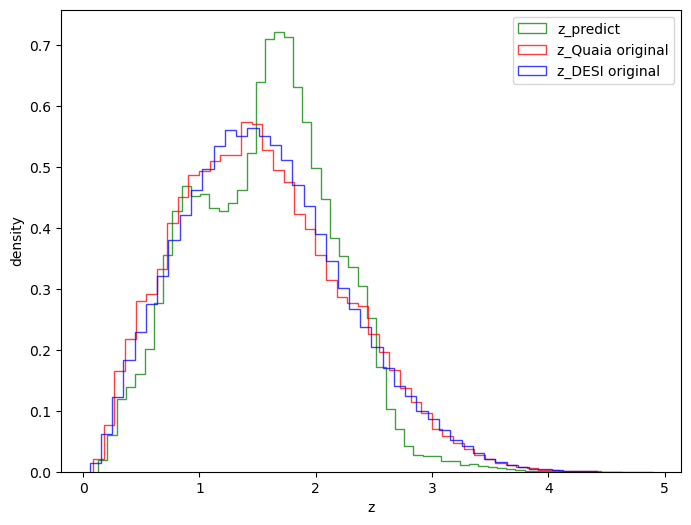

In [32]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_pred, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_DESI original')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

In [20]:
#SDSS based

# mask setup
mask = np.ones(len(data), dtype=bool)
for f in features + ['SDSS_Z']:
    mask &= ~np.isnan(data[f])

# Train setup
X = np.array([data[f][mask] for f in features]).T
y = data['SDSS_Z'][mask]

# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=11, weights='uniform')  # or maybe distance weights?
knn.fit(X_scaled, y)

# redshift estimation
z_preds = knn.predict(X_scaled)

mae = mean_absolute_error(y, z_preds)
rmse = np.sqrt(mae)

print(f"MAE: {mae:.4f}", f"RMSE: {rmse:.4f}")
print(z_preds[:5])

MAE: 0.2507 RMSE: 0.5007
[2.49346994 2.35729163 0.66716116 0.3851247  0.69838003]


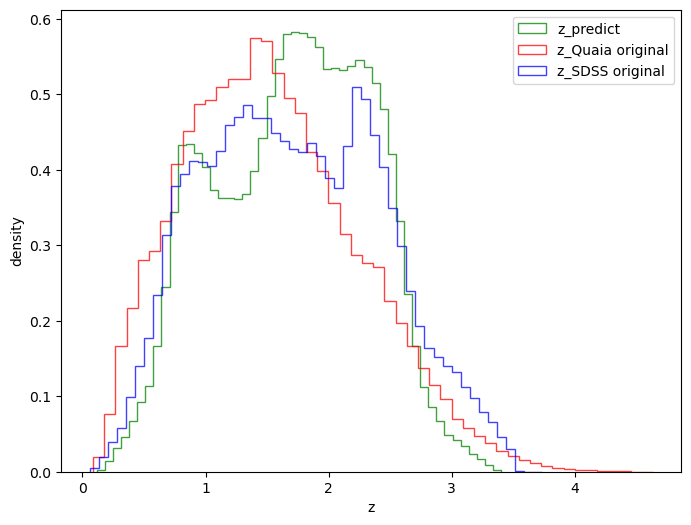

In [21]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_preds, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_SDSS original')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

In [22]:
#SDSS and DESI both

# mask setup
mask = ~np.isnan(data['SDSS_Z']) & ~np.isnan(data['DESI_Z'])
for f in features:
    mask &= ~np.isnan(data[f])

filtered_data = data[mask]


# Train setup
X = np.array([data[f][mask] for f in features]).T
y = filtered_data['DESI_Z']

# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=11, weights='uniform')  # or maybe distance weights?
knn.fit(X_scaled, y)

# redshift estimation
z_predsd = knn.predict(X_scaled)

mae = mean_absolute_error(y, z_predsd)
rmse = np.sqrt(mae)

print(f"MAE: {mae:.4f}", f"RMSE: {rmse:.4f}")
print(z_predsd[:5])

MAE: 0.2501 RMSE: 0.5001
[2.4541789  2.34369475 0.73538218 0.71253807 1.78785344]


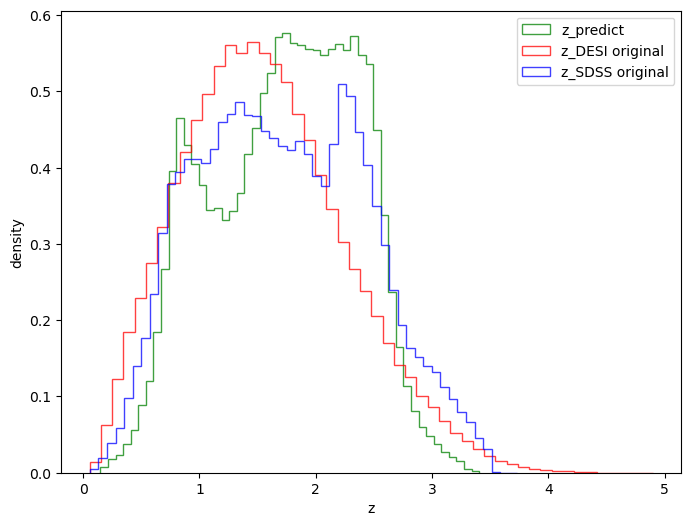

In [23]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_predsd, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_DESI original')
plt.hist(data['SDSS_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_SDSS original')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

In [24]:
#length check
print(f"DESI based: {len(z_pred)}"+"\n",
      f"SDSS based: {len(z_preds)}"+"\n",
      f"both based: {len(z_predsd)}")

DESI based: 47222
 SDSS based: 218546
 both based: 101233


In [25]:
#reverse version?
#DESI based
features = ['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
            'mag_w1_vg', 'mag_w2_vg',
            'DESI_Z'
            ]   # Quaia_W12 is not used in this part.

# mask setup
mask = np.ones(len(data), dtype=bool)
for f in features + ['redshift_quaia']:
    mask &= ~np.isnan(data[f])

# Train setup
X = np.array([data[f][mask] for f in features]).T
y = data['redshift_quaia'][mask]

# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsRegressor(n_neighbors=11, weights='uniform')  # or maybe distance weights?
knn.fit(X_scaled, y)

# redshift estimation
z_pred_rd = knn.predict(X_scaled)   # Reversed DESI z prediction

mae = mean_absolute_error(y, z_pred_rd)
rmse = np.sqrt(mae)

print(f"MAE: {mae:.4f}", f"RMSE: {rmse:.4f}")
print(z_pred_rd[:5])
print(f"number of predicted : {len(z_pred_rd)}")

print(f"number of train: {len(X)}")

MAE: 0.1207 RMSE: 0.3475
[0.42420676 1.74174195 1.50254062 2.40945443 2.76555006]
number of predicted : 314807
number of train: 314807


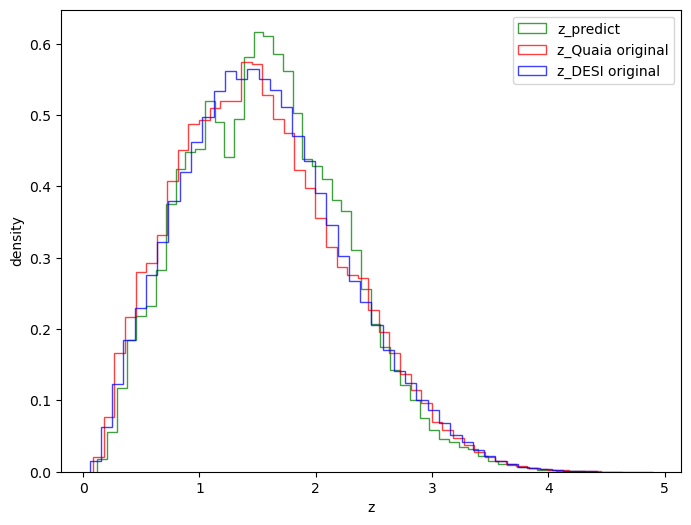

In [26]:
#histogram
alpha = 0.75
lw = 1.5
density = True
histtype = 'step'

plt.figure(figsize=(8,6))
plt.hist(z_pred_rd, bins=50, alpha=alpha, color='g', lw=lw, density=density, histtype=histtype, label='z_predict')
plt.hist(data['redshift_quaia'], bins=50, alpha=alpha, color='r', lw=lw, density=density, histtype=histtype, label='z_Quaia original')
plt.hist(data['DESI_Z'], bins=50, alpha=alpha, color='b', lw=lw, density=density, histtype=histtype, label='z_DESI original')

plt.xlabel('z')
plt.ylabel('density')
plt.legend()

In [27]:
header = superset[1].header


nan_mask_test = np.isnan(X).any(axis=1)

new_col_zphot = np.full(data.shape[0], np.nan) 

test_indices = np.where(mask)[0]
valid_test_indices = test_indices[~nan_mask_test]  

# Adding the estimated values into new fits files
new_col_zphot[valid_test_indices] = z_pred_rd

new_cols = fits.ColDefs([
    fits.Column(name='predicted_z', format='E', array=new_col_zphot)
])

hdu = fits.BinTableHDU.from_columns(data.columns + new_cols, header=header)

hdu.writeto("kNNtestnew.fits", overwrite=True)

In [28]:
new = fits.open("kNNtestnew.fits")
newdata = new[1].data

predz = newdata['predicted_z']
desiz = newdata['DESI_Z']
sdssz = newdata['SDSS_Z']
quaiaz = newdata['redshift_quaia']

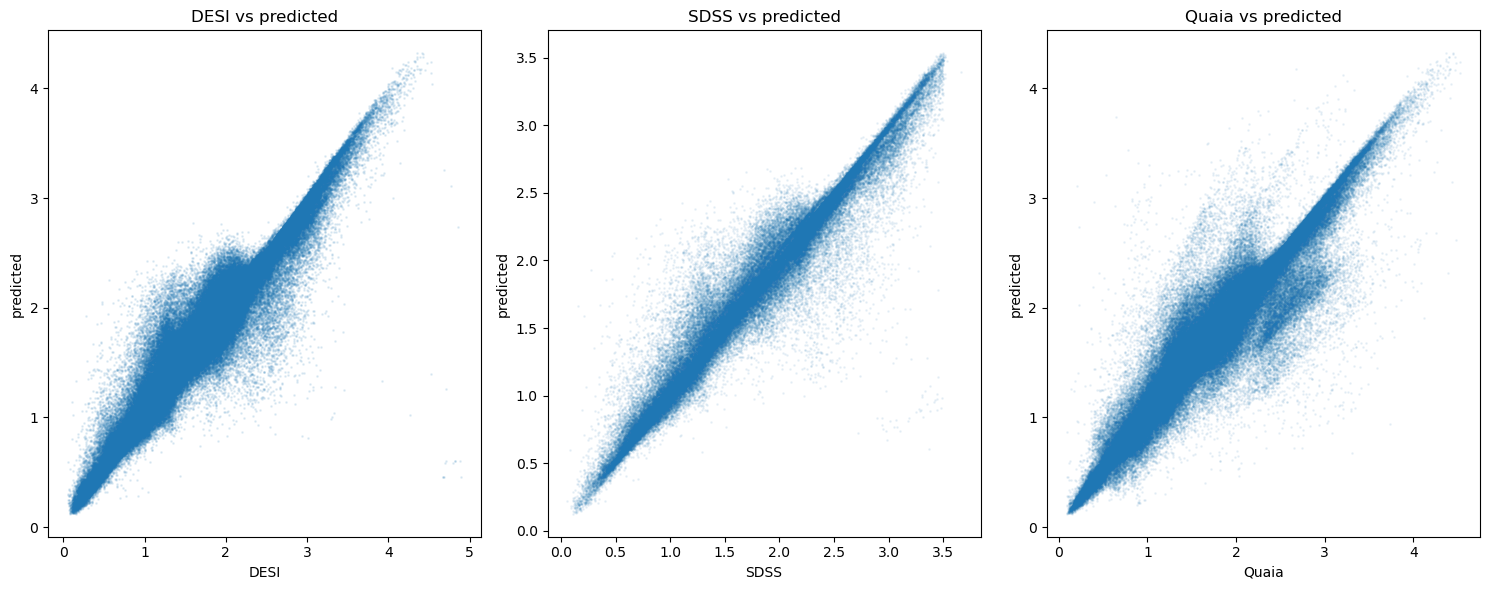

In [29]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.scatter(desiz, predz, alpha=0.1, s=1)
plt.xlabel("DESI")
plt.ylabel("predicted")
plt.title("DESI vs predicted")

plt.subplot(1, 3, 2)
plt.scatter(sdssz, predz, alpha=0.07, s=1)
plt.xlabel("SDSS")
plt.ylabel("predicted")
plt.title("SDSS vs predicted")

plt.subplot(1, 3, 3)
plt.scatter(quaiaz, predz, alpha=0.07, s=1)
plt.xlabel("Quaia")
plt.ylabel("predicted")
plt.title("Quaia vs predicted")

plt.tight_layout()
plt.show()


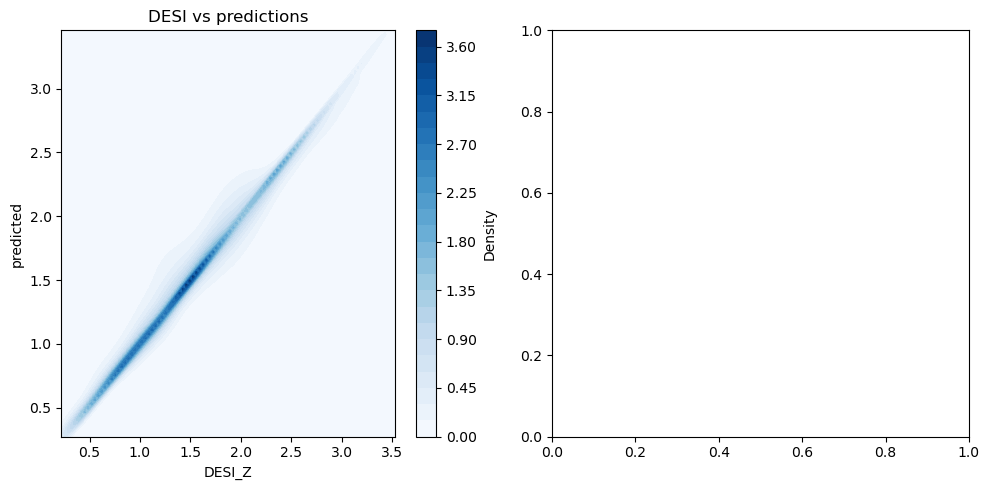

In [30]:
def contour_density_lineplot(x, y, ax, xlabel, ylabel, title, gridsize=100, levels=30, cmap='Blues'):
    # NaN eliminate
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)

    # Grid
    xmin, xmax = np.percentile(x, [0.5, 99.5])
    ymin, ymax = np.percentile(y, [0.5, 99.5])
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, gridsize),
        np.linspace(ymin, ymax, gridsize)
    )
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # contour
    cf = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.colorbar(cf, ax=ax, label='Density')

fig, axs = plt.subplots(1, 2, figsize=(10, 5), facecolor='white')

contour_density_lineplot(desiz, predz, axs[0],
                        'DESI_Z', 'predicted', 'DESI vs predictions')

# contour_density_lineplot(sdssz, predz, axs[0],
                        # 'SDSS_Z', 'predicted', 'SDSS vs predictions')

plt.tight_layout()
plt.show()